# CS 640 - 2025 Fall - Homework 5

In this homework, you will define a Markov decision process describing a cat moving on a 32 x 32 grid looking for a fish.
This will extend last week's Markov reward process by giving the cat agency to seek out the fish.

## Instructions

1. Follow the instructions below to construct and analyze the Markov decision process.
2. Run all the cells so that all the check cells are updated.
3. Answer the question at the bottom.
4. Submit your notebook in Gradescope.


In [1]:
from xml.etree.ElementTree import QName

import matplotlib.pyplot as plt
import numpy as np
import torch

## State Descriptions

You will construct a Markov decision problem based on the following specification (same as homework 4).
1. The states are numbered from 0 to 1024 (inclusive).
2. The state 1024 is a special done state.
3. For state s from 0 to 1023, the state number encodes coordinates as follows.
  * x = s % 32
  * y = s / 32 (integer division)
  * x and y represent the location of a cat in a 32x32 grid.
4. At the state corresponding to x=16,y=16, there is a fish unless the cat is also there.

The following function `print_state` will visualize the state.

In [2]:
def print_state(s):
    assert 0 <= s <= 1024

    print("STATE", s)

    if s < 1024:
        # normal state indicating y, x coordinates
        output = ['🪨' for _ in range(1024)]
        output[16*32+16] = '🐟'
        output[s] = '🐱'
        for i in range(0, 1024, 32):
            print(''.join(output[i:i+32]))
    else:
        print("DONE")

    print("")

for s in (0, 2 * 32 + 5, 16*32+16, 1023, 1024):
    print_state(s)

STATE 0
🐱🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🐟🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨🪨
🪨🪨

## Actions

In any state, the cat will have 4 possible actions.
1. Up. The cat tries to change its $y$ coordinate by -1.
2. Down. The cat tries to change its $y$ coordinate by +1.
3. Left. The cat tries to change its $x$ coordinate by -1.
4. Right. The cat tries to change its $x$ coordinate by +1.

If the up/down descriptions do not make sense, consider that the first row when printing corresponds to $y=0$ and the last row printed corresponds to $y=31$.

## State Transitions

For each action $a$, construct a transition matrix $P_a$ based on the following rules.

1. $P_a$ should be 1025x1025.
2. $P_a[i,j]$ should hold the probability of transitioning from state i to j in one step.
3. If the state is 1024 (the done state), the state stays the same with probability 1.
4. If the state is 528 (cat is on the fish), the state changes to 1024 with probability 1.
5. If the action $a$ corresponds to moving off the grid, then the state stays the same with probability 1.
6. Otherwise, for any other state $s$,
    * For any state $s'$ representing locations that are adjacent horizontally or vertically besides the state that the cat intends to reach, there is a 5% of transitioning from $s$ to $s'$.
    * The state to which the cat intends to move has the remaining probability (this should be 0.85, 0.90 or 0.95).
    * The probability of transitioning to a state representing a non-adjacent location is zero.


In [3]:
# Construct transition matrices for each action
grid_size = 32
n_states = grid_size * grid_size + 1  # 1025 including done state
# Define action deltas for moving the cat
actions = {
    "up": (-1, 0),
    "down": (1, 0),
    "left": (0, -1),
    "right": (0, 1),
}
# Initialize a transition matrix for each action
P = {}
for a_name, (dy, dx) in actions.items():
    P_a = np.zeros((n_states, n_states))
    for s in range(n_states):
        # The terminal 'done' state is absorbing
        if s == n_states - 1:
            P_a[s, s] = 1.0
            continue
        # If the cat is on the fish, transition to the done state
        if s == 16 * grid_size + 16:
            P_a[s, n_states - 1] = 1.0
            continue
        # Decode the current state's (y, x) coordinates
        y, x = divmod(s, grid_size)
        new_y, new_x = y + dy, x + dx
        # If the intended move would take the cat off the grid, it stays put
        if not (0 <= new_y < grid_size and 0 <= new_x < grid_size):
            P_a[s, s] = 1.0
            continue
        # Determine the slip directions (all other adjacent moves)
        slip_dirs = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        slip_dirs.remove((dy, dx))
        # Collect valid slip neighbors and assign 5% probability to each
        valid_slips = []
        for sy, sx in slip_dirs:
            ny, nx = y + sy, x + sx
            if 0 <= ny < grid_size and 0 <= nx < grid_size:
                valid_slips.append((ny, nx))
        # Assign 0.05 probability to each valid slip
        for ny, nx in valid_slips:
            s_prime = ny * grid_size + nx
            P_a[s, s_prime] += 0.05
        # Assign the remaining probability to the intended next state
        intended_state = new_y * grid_size + new_x
        P_a[s, intended_state] += 1.0 - 0.05 * len(valid_slips)
    # Save the transition matrix for this action
    P[a_name] = P_a


## State Rewards

Construct a reward vector R based on the following rules.
The reward does not depend on the action.

1. R should be 1025x1.
2. R[i] should hold the reward after state i.
3. The reward after state 528 (cat is on fish) is 100.
4. The reward for all other states is 0.

In [4]:
# Construct reward vector
n_states = 32 * 32 + 1
R = np.zeros(n_states)
# Reward of 100 when the cat reaches the fish (state 528)
R[16 * 32 + 16] = 100.0


## Optimal State Values

Use **value iteration** to compute the value function $v_*$ for each state using $\gamma=0.9$ and save it in $v$.

In [5]:
# Use value iteration to compute the optimal state values v_*
# Discount factor
gamma = 0.9
n_states = 32 * 32 + 1
# Initialize value function to zeros
v = np.zeros(n_states)
# Convergence threshold
threshold = 1e-8
while True:
    new_v = v.copy()
    # Update all states except the done state
    for s in range(n_states - 1):
        # Compute expected return for each action and take the maximum
        action_returns = []
        for a_name in actions:
            # Expected return for taking action a from state s
            expected_return = np.dot(P[a_name][s], R + gamma * v)
            action_returns.append(expected_return)
        new_v[s] = max(action_returns)
    # Explicitly set the value of the done state to zero
    new_v[-1] = 0.0
    # Check for convergence
    if np.max(np.abs(new_v - v)) < threshold:
        v = new_v
        break
    v = new_v
# Convert v to a Python list for compatibility with later code
v = v.tolist()


### Check $v_*$ values.

Run these cells without changing their code.

In [6]:
# done state
v[1024]

0.0

In [7]:
# cat arrived at fish
v[528]

0.0

In [8]:
# cat next to fish
v[529]

96.39895759218216

In [9]:
# cat farther from fish
v[530]

83.72861722480366

## Visualize $v_*$.

Run this cell without changing its code.

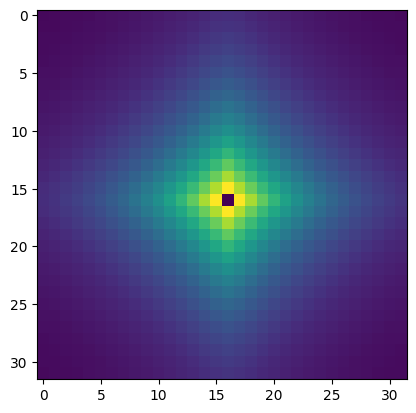

In [10]:
plt.imshow(np.asarray(v)[:1024].reshape(32, 32));

## Optimal State-Action Values

Use **q-learning** to compute the state-action value function $q_*$ using $\gamma$ and save it in `q`.
`q` should be constructed so that `q[s][a]` returns the value $q_*(s,a)$ where $s$ is an integer from 0 to 1024 (inclusive) and $a$ is one of the strings "up", "down", "left" or "right".

In [11]:
# Compute the optimal state-action values q_* from the value function v
# Discount factor
gamma = 0.9
# List of action names to maintain a consistent order
actions_list = list(actions.keys())
# Ensure v is a numpy array for dot products
v_array = np.array(v)
q = {}
for s in range(n_states):
    q[s] = {}
    for a_name in actions_list:
        # Expected return for taking action a in state s
        q[s][a_name] = float(np.dot(P[a_name][s], R + gamma * v_array))


In [46]:
import numpy as np

# Parameters
gamma = 0.9
theta = 1e-6  # Convergence threshold
max_iterations = 1000

# Get list of actions
actions_list = list(actions.keys())

# Initialize Q-table: Q[s][a] = 0 for all s, a
q = {}
for s in range(n_states):
    q[s] = {a: 0.0 for a in actions_list}

# Q-Iteration: Directly iterate on Q until convergence
print("Running Q-Iteration to find Q*...")

for iteration in range(max_iterations):
    q_old = {s: q[s].copy() for s in range(n_states)}  # Save old Q

    # Update all Q(s,a) values
    for s in range(n_states):
        for a in actions_list:
            # Bellman optimality equation for Q:
            # Q*(s,a) = Σ P(s'|s,a) [R(s,a,s') + γ max_{a'} Q*(s',a')]
            q_sum = 0.0
            for s_prime in range(n_states):
                # Transition probability P(s'|s,a)
                prob = P[a][s][s_prime]

                # Reward
                reward = R[s_prime]  # or R[s][a][s_prime] depending on your setup

                # max_{a'} Q(s',a')
                max_q_next = max(q_old[a].values())

                # Add to expectation
                q_sum += prob * (reward + gamma * max_q_next)

            q[s][a] = q_sum

    # Check convergence
    max_change = 0.0
    for s in range(n_states):
        for a in actions_list:
            change = abs(q[s][a] - q_old[s][a])
            max_change = max(max_change, change)

    if max_change < theta:
        print(f"✓ Q* converged in {iteration + 1} iterations")
        break
else:
    print("⚠ Warning: Maximum iterations reached")

print("✓ Q* computed!")

Running Q-Iteration to find Q*...
✓ Q* converged in 68 iterations
✓ Q* computed!


### Check $q_*$ values.

Run these cells without changing their code.

In [50]:
# done state
(q[1024]["up"], q[1024]["down"], q[1024]["left"], q[1024]["right"])

(np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0))

In [48]:
# cat arrived at fish

(q[528]["up"], q[528]["down"], q[528]["left"], q[528]["right"])

(np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0))

In [51]:
# cat next to fish

(q[529]["up"], q[529]["down"], q[529]["left"], q[529]["right"])

(np.float64(77.44831612871018),
 np.float64(77.44831612871016),
 np.float64(96.39895759218216),
 np.float64(76.68356199404079))

In [43]:
# cat farther from fish

(q[530][0], q[530][1], q[530][2], q[530][3])

(np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0))

## Extract Optimal Policy from $q_*$.

Construct an optimal policy based on $q_*$.
Save it in a variable `pi`

In [52]:
# Extract an optimal policy from q_*
actions_list = list(actions.keys())
pi = []
for s in range(n_states):
    # For the done state, choose an arbitrary action (e.g., 'up')
    if s == n_states - 1:
        pi.append('up')
        continue
    # Select the action with the highest q-value
    best_action = actions_list[0]
    best_value = q[s][best_action]
    for a_name in actions_list[1:]:
        if q[s][a_name] > best_value:
            best_action = a_name
            best_value = q[s][a_name]
    pi.append(best_action)


### Check $\pi$ values

Run these cells without changing their code.

In [53]:
# done state
pi[1024]

'up'

In [54]:
# cat arrived at fish
pi[528]

'up'

In [55]:
# cat next to fish
pi[529]

'left'

In [56]:
# cat farther from fish
pi[530]

'left'

## Visualize $\pi$.

Run this cell without changing its code.

In [57]:
pi_visualized = ["🔥" for _ in range(1024)]

for i in range(1024):
    if pi[i] == "up":
        pi_visualized[i] = "⬆️"
    elif pi[i] == "down":
        pi_visualized[i] = "⬇️"
    elif pi[i] == "left":
        pi_visualized[i] = "⬅️"
    elif pi[i] == "right":
        pi_visualized[i] = "➡️"
    else:
        raise Exception(f"Unknown action : {pi[i]!r}")

pi_visualized[16*32+16] = '🐟'

for i in range(0, 1024, 32):
    print(''.join(pi_visualized[i:i+32]))

➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️⬇️⬇️⬇️⬇️⬇️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬇️
⬇️⬇️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬇️⬇️
⬇️⬇️⬇️➡️➡️➡️➡️➡️➡️➡️➡️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬇️⬇️⬇️
⬇️⬇️⬇️⬇️➡️➡️➡️➡️➡️➡️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬅️⬅️⬅️⬅️⬅️⬇️⬇️⬇️⬇️
⬇️⬇️⬇️⬇️⬇️➡️➡️➡️➡️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬅️⬅️⬅️⬇️⬇️⬇️⬇️⬇️
⬇️⬇️⬇️⬇️⬇️➡️➡️➡️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬅️⬇️⬇️⬇️⬇️⬇️⬇️
⬇️⬇️⬇️⬇️⬇️⬇️➡️➡️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️
⬇️⬇️⬇️⬇️⬇️⬇️⬇️➡️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️
⬇️⬇️⬇️⬇️⬇️➡️➡️➡️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬅️⬇️⬇️⬇️⬇️⬇️⬇️
⬇️⬇️⬇️⬇️➡️➡️➡️➡️➡️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬅️⬅️⬅️⬅️⬇️⬇️⬇️⬇️
⬇️⬇️⬇️➡️➡️➡️➡️➡️➡️➡️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬅️⬅️⬅️⬅️⬅️⬅️⬇️⬇️⬇️
⬇️⬇️➡️➡️➡️➡️➡️➡️➡️➡️➡️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬇️⬇️
⬇️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬇️
⬇️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️⬇️⬇️⬇️⬇️⬇️⬇️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬇️
➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️⬇️⬇️⬇️⬇️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️⬅️
➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡